# The Allegheny County Summer Reading Program, May 2021

**Group member names:** Hui-Chen Betty Liu, Carly Jones, Emily Reece, Michelle Degutis  
**Group member andrewIDs:** huichenl, carlyjon, ejreece, mdegutis

## Notebook Overview
This notebook focuses on two objectives for the Allegheny County Summer Reading Program:  
    1. Minimize the total/weighted travel distance of the population served
    2. Minimize the travel distance for any child eligible to participate in the program
In addition to the objectives above, the notebook explores optimal solutions for different program scenarios including:
    1. Scenario 1
    2. Scenario 2

### Overview of files and variables required
Age_group: 6-8 years

Files we need
1. Dist: tract_euclidean_distance.csv (402 tracts total)
2. Population: census_var_tract 

1st implementation: Min overall distance
Objective: Minimize total distance traveled for kiddos (utility)
Constraints:
1. Tract can only be assigned if library is in use
2. All tracts must be assigned to one and only one library (sum=402)
3. Capacity: each library site selected must be assigned greater than L # students - this will enforce the number of libraries selected (so presumably, we won't really need an additional constaint for that)
4. Assumption we made: 75% of students from each tract will actually use the program
5. Question/consideration: how many staffers on site for the number of students? Etc etc
6. Considerations about how many students actually remain on site vs. others who show up/leave, etc.
7. Arrival distribution considerations (future work...)



2nd implementation: Equity (minimax)

Questions for group:
1. Do we need a constraint on the number of libraries overall, if we have the min capacity constaint implemented?

In [79]:
# Import necessary libraries
from gurobipy import *
import csv
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Read in & Process Data

### Distance Data

In [58]:
# Create a 2D 402x149 array representing the euclidean distance from each tract area to each library
tract_distance = np.genfromtxt("tract_euclidean_distance.csv", dtype=np.float, delimiter=',', encoding='utf-8-sig')
tract_dist = tract_distance[1:,1:]
num_tracts, num_libs = tract_dist.shape

# Print the total number of tract areas and libraries
print('Total tract areas: ' + str(num_tracts))
print('Total potential libraries: ' + str(num_libs))

Total tract areas: 402
Total potential libraries: 149


### Population Data

In [59]:
# Create a vector of size 402 representing the total number of eligible students in each tract area
census_var_tract = pd.read_csv("census_vars_tract.csv")
tract_population = census_var_tract['est_total_pop_u18_in_households_6to8yrs']
tract_pop = np.array(tract_population)

# Calculate the total population of eligible students throughout the county
overall_pop = tract_pop.sum()

In [60]:
# Estimate how many students each library will need to serve
# Estimate dependent on the number of libraries selected for the program

percent_libs_selected = 0.5 # the percent of libraries we expect to use
num_libs_selected = int(num_libs*percent_libs_selected) # the number of libraries we expect to use
percent_expected = 0.75 # the percent of eligible students we expect to participate
min_per_site = int((overall_pop*.75)/75) # estimated average number of students each library must serve

# Print the estimated average number of students each selected library must serve
print('If we utilize ' + str(int(op_portion*100)) + '% of libraries, each library will need to serve an average of ' + str(min_per_site) + ' kids.') 

If we utilize 50% of libraries, each library will need to serve an average of 363 kids.


## Objective 1: Minimize the total travel distance of the population served
### Step 1.1: Instantiate Model (m1), Define Indices, & Set Up Objective Function

In [61]:
# Indices for tract areas and libraries
tract_areas = range(402)
library_sites = range(149)

# min capacity for libraries
min_capacity = 100

# Set up model object
m1 = Model()

# Define variables and variable bounds
y = m1.addVars(tract_areas, library_sites, vtype=GRB.BINARY) # whether tract area [i] is assigned to library [j]
x = m1.addVars(library_sites, vtype=GRB.BINARY) # whether library [j] is selected for the program

# Set up objective function
m1.modelSense = GRB.MINIMIZE 
m1.setObjective(sum(sum(percent_expected*tract_pop[i] * tract_dist[i,j] * y[i,j] for j in library_sites) for i in tract_areas))

### Step 1.2: Define Constraints

In [62]:
# Constraint for minimum capacity of libraries selected
for j in library_sites :
    m1.addConstr(sum(percent_expected*tract_pop[i]*y[i,j] for i in tract_areas) >= min_capacity)
    
# Constaints for number of shelters allowed to be built
#m.addConstr(sum(x[j] for j in shelt_areas) <= 10) # double check this one?

# Constraint to ensure that tract area cannot be assigned to library unless library is selected
for i in tract_areas:
    for j in library_sites:
        m1.addConstr(y[i,j] <= x[j])

# Constraint to ensure tract area can only be assigned to one library site
for i in tract_areas:
    m1.addConstr(sum(y[i,j] for j in library_sites)==1)    

### Step 1.3: Run Model

In [66]:
# Solve & print optimal solution
m1.optimize()
print()
print('Total distance across all expected program participants:',m1.objVal)
print()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 60449 rows, 60047 columns and 235122 nonzeros
Model fingerprint: 0x67c3716a
Variable types: 0 continuous, 60047 integer (60047 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+02]
  Objective range  [9e-03, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolved: 521 rows, 55428 columns, 110856 nonzeros

Continuing optimization...


Cutting planes:
  Gomory: 11
  Cover: 107
  MIR: 172
  StrongCG: 138
  Flow cover: 82
  Inf proof: 1
  Zero half: 6
  RLT: 20

Explored 15878 nodes (782038 simplex iterations) in 0.05 seconds
Thread count was 8 (of 8 available processors)

Solution count 10: 478.401 478.401 478.421 ... 479.997

Optimal solution found (tolerance 1.00e-04)
Best objective 4.784005401069e+02, best bound 4.783530684449e+02, gap 0.0099%

Total distance across all expected program particip

In [106]:
# Create a 2D array of size 402x149 showing what tract area is assigned to what library
libraries_assigned_m1 = np.array([y[i,j].x for i in tract_areas for j in library_sites]).reshape(num_tracts,num_libs)

# Count and print how many libraries are in use under objective 1
num_tracts_assigned_to_libs_m1 = libraries_assigned_m1.sum(axis=0)
libs_in_use_m1 = np.count_nonzero(num_tracts_assigned_to_libs_m1)
print('The summer reading program utilizes ' + str(libs_in_use_m1) + ' libraries under objective #1.')

The summer reading program utilizes 149 libraries under objective #1.


### Step 1.4: Visualize & Interpret Model Solution

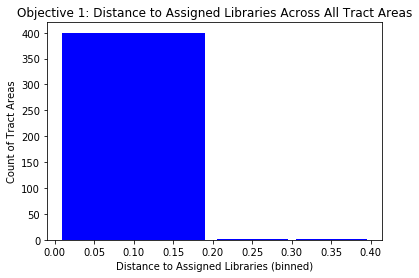

In [68]:
# Create histogram of the distance to the assigned libraries across all tract areas
assignments = []
for i in tract_areas:
    for j in library_sites:
        assignments.append(y[i,j].x)
assignments=np.array(assignments)
assignments=np.reshape(assignments, (num_tracts,num_libs))
assignedDistances = tract_dist*assignments
assignedDistances = np.sum(assignedDistances, axis=1)
assignedDistances1 = assignedDistances[assignedDistances!=0]


fig1 = plt.figure()
plt.hist(assignedDistances1, bins = [0,.2,.3,.4], rwidth = 0.9, color = 'Blue')
plt.xlabel("Distance to Assigned Libraries (binned)")
plt.ylabel("Count of Tract Areas") 
plt.title("Objective 1: Distance to Assigned Libraries Across All Tract Areas") 
plt.show()

## Objective 2: Minimize the maximum travel distance for any program participant
### Step 2.1: Instantiate Model (m2), Define Indices, & Set Up Objective Function

In [69]:
m2 = Model() # Set up model object

y2 = m2.addVars(tract_areas, library_sites, vtype=GRB.BINARY) # whether tract area [i] is assigned to library [j]
x2 = m2.addVars(library_sites, vtype=GRB.BINARY) # whether library [j] is selected for the program

# define our new somewhat arbitrary decision variable, L
L = m2.addVars(1) 

m2.setObjective(L[0], GRB.MINIMIZE)

### Step 2.2: Define Constraints

In [70]:
# Constraint that ensures we choose the smallest L possible (minimax)
for i in tract_areas:
    for j in library_sites:
        m2.addConstr(y2[i,j]*tract_dist[i,j] <= L[0])

# Constraint for minimum capacity of libraries selected
for j in library_sites :
    m2.addConstr(sum(percent_expected*tract_pop[i]*y2[i,j] for i in tract_areas) >= min_capacity)
    
# Constaints for number of shelters allowed to be built
#m.addConstr(sum(x[j] for j in shelt_areas) <= 10) # double check this one?

# Constraint to ensure that tract area cannot be assigned to library unless library is selected
for i in tract_areas:
    for j in library_sites:
        m2.addConstr(y2[i,j] <= x2[j])

# Constraint to ensure tract area can only be assigned to one library site
for i in tract_areas:
    m2.addConstr(sum(y2[i,j] for j in library_sites)==1)  

### Step 2.3: Run Model

In [74]:
# Solve & print optimal solution
m2.optimize()
print()
print('Largest distance between tract areas and libraries:',m2.objVal)
print()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 120347 rows, 60048 columns and 354918 nonzeros
Model fingerprint: 0xe6edd36b
Variable types: 1 continuous, 60047 integer (60047 binary)
Coefficient statistics:
  Matrix range     [3e-04, 4e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolved: 60046 rows, 59889 columns, 234443 nonzeros

Continuing optimization...


Cutting planes:
  Cover: 7
  MIR: 33
  StrongCG: 10
  RLT: 55

Explored 1 nodes (72564 simplex iterations) in 0.03 seconds
Thread count was 8 (of 8 available processors)

Solution count 10: 0.0730282 0.094132 0.128094 ... 0.408493

Optimal solution found (tolerance 1.00e-04)
Best objective 7.302823100000e-02, best bound 7.302823100000e-02, gap 0.0000%

Largest distance between tract areas and libraries: 0.073028231



In [107]:
# Create a 2D array of size 402x149 showing what tract area is assigned to what library
libraries_assigned_m2 = np.array([y[i,j].x for i in tract_areas for j in library_sites]).reshape(num_tracts,num_libs)

# Count and print how many libraries are in use under objective 2
num_tracts_assigned_to_libs_m2 = libraries_assigned_m2.sum(axis=0)
libs_in_use_m2 = np.count_nonzero(num_tracts_assigned_to_libs_m2)
print('The summer reading program utilizes ' + str(libs_in_use_m2) + ' libraries under objective #2.')

The summer reading program utilizes 149 libraries under objective #2.


### Step 2.4: Visualize & Interpret Model Solution

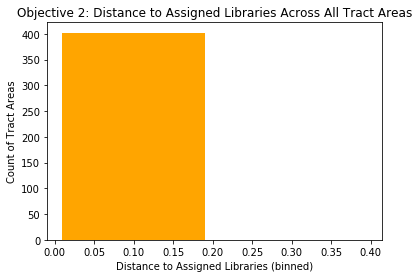

In [76]:
# Create histogram of the distance to the assigned libraries across all tract areas
assignments = []
for i in tract_areas:
    for j in library_sites:
        assignments.append(y2[i,j].x)
assignments=np.array(assignments)
assignments=np.reshape(assignments, (num_tracts,num_libs))
assignedDistances = tract_dist*assignments
assignedDistances = np.sum(assignedDistances, axis=1)
assignedDistances2 = assignedDistances[assignedDistances!=0]

fig2 = plt.figure()
plt.hist(assignedDistances2, bins = [0,.2,.3,.4], rwidth = 0.9, color = 'Orange')
plt.xlabel("Distance to Assigned Libraries (binned)")
plt.ylabel("Count of Tract Areas") 
plt.title("Objective 2: Distance to Assigned Libraries Across All Tract Areas") 
plt.show()

## Comparing Solutions: Objective 1 (Utility) vs. Objective 2 (Equity)

In [77]:
model1_distances = (libraries_assigned_m1*tract_dist).sum(axis=1)
model2_distances = (libraries_assigned_m2*tract_dist).sum(axis=1)

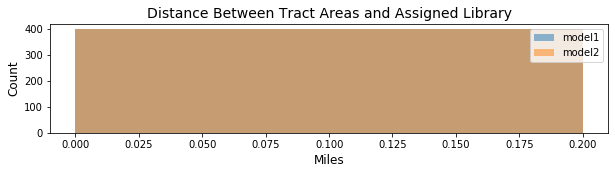

In [81]:
bins = np.arange(0,0.4, 0.2).tolist()

plt.hist(model1_distances, bins, alpha=0.5, label='model1')
plt.hist(model2_distances, bins, alpha=0.5, label='model2')
plt.legend(loc='upper right')
plt.title('Distance Between Tract Areas and Assigned Library', fontsize=14)
plt.xlabel('Miles', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.rcParams["figure.figsize"] = (10,2)
plt.show()

## Dealing with Different Scenarios
The following models use the same objectives described above under 3 different scenarios:
    1. Focus soley on low-income tract areas
    2. Vary minimum library capacity
    3. Vary expected percent of participating students

### Scenario 1: Rerun the Second Objective (m2) Focusing Soley on Low-Income Tracts

In [109]:
# run m2 with a subset of tracts (pick bottom 50% tracks based on income)

### Scenario 2: Rerun the First Objective (m1) Varying Minimum Library Capacity

In [110]:
# run m1 with various min library capacities (variable name = min_capacity)

### Scenario 3: Rerun the First Objective (m1) Varying the Expected Percent of Participating Students

In [111]:
# run m1 with various expected number of participating students (variable name = percent_expected)